Hi!
This is Miguel's project proposal for The Data Incubator 2018. 
It's a sneak preview on the effect of climate on crime levels on NYC. The results suggest a clear correlation between temperature and crime counts, specially with some specific types of felonies.
Crime data is obtained directly from https://opendata.cityofnewyork.us/ and weather data is scrapped from https://www.wunderground.com/.

Let's begin!

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import linregress

# global settings
MIGUELS_SELECTED_COLOR_CODES = ['#1059ce',
                                '#08892a']

YEARS_TO_PLOT                = [2015,2016]

OFFENSES_TO_TEST             = ['harassment','criminal trespass','petit larceny']
MAX_LABEL_DIGITS             = 20

# matplotlib preferences
plt.rc('font', family='serif') 

## smoothCurve
def smoothCurve(yValues,frequencyCutRatio=5.):
    """
    smoothCurve
    this simple function reduces the high frequency variations of yValues
    making use of Fourier Transforms
    """
    w           = np.fft.rfft(yValues)
    ws          = w*w
    w[ws<np.max(ws)/frequencyCutRatio] = 0.
    return np.fft.irfft(w,len(yValues))
    
# expand pandas screen output
pd.set_option('display.expand_frame_repr', False)

In [2]:
# since the original database is massively huge and I'd like to execute this quickly and try
# different things, I'll divide the files according to occurence year

# read nypd crime data from the huge (1.3GB) csv file
nypdDataDfRed = None

for year in YEARS_TO_PLOT:
    print('Gathering crime data for %d' % year)
    try:
        filename    = 'NYPD_Complaint_Data_Historic_%d.csv' % year
        nyPdDataYear = pd.read_csv(filename)
        nyPdDataYear['CMPLNT_FR_DT']  = pd.to_datetime(nyPdDataYear['CMPLNT_FR_DT'],errors='coerce').dt.date
    except:
        nypdDataDf                  = pd.read_csv('NYPD_Complaint_Data_Historic.csv',error_bad_lines=False,dtype='unicode')
        print(' - full database data successfuly imported')
        nypdDataDf['CMPLNT_FR_DT']  = pd.to_datetime(nypdDataDf['CMPLNT_FR_DT'],errors='coerce')
        print(' - data type changed')
        nyPdDataYear               = nypdDataDf.groupby([nypdDataDf['CMPLNT_FR_DT'].dt.year]).get_group(year)
        print(' - saving reduced (single year only) NYPD complaint data')
        nyPdDataYear.to_csv('NYPD_Complaint_Data_Historic_%s.csv' % year)
    print(' - current database size:', nyPdDataYear.size)
    if nypdDataDfRed is None:
        nypdDataDfRed = nyPdDataYear
    else:
        nypdDataDfRed = nypdDataDfRed.append(nyPdDataYear)

print('> Total crime database size:', nypdDataDfRed.size)

# group by date already
crimePerDayCounts = nypdDataDfRed.groupby('CMPLNT_FR_DT',as_index=True).count()['CMPLNT_NUM'] # we can count the number of different unique ids

# read weather
weatherDf                           = pd.read_csv('KNYC.csv')
print('> Total weather database size:', weatherDf.size)

# fix data
weatherDf['date']                   = pd.to_datetime(weatherDf['date']).dt.date
weatherDf['actual_mean_temp']       = pd.to_numeric(weatherDf['actual_mean_temp'],errors='coerce')
weatherDf['actual_precipitation']   = pd.to_numeric(weatherDf['actual_precipitation'],errors='coerce')

#weatherDf = weatherDf.groupby(weatherDf['date'].dt.year).get_group(2016)

dates = crimePerDayCounts.index.values
crimesPerDate = crimePerDayCounts.values
weatherDates = weatherDf['date']
weatherTemps = weatherDf['actual_mean_temp'].values
weatherPrecs = weatherDf['actual_precipitation'].values

Gathering crime data for 2015
 - current database size: 11925775
Gathering crime data for 2016
 - current database size: 11707250
> Total crime database size: 23633025
> Total weather database size: 15351


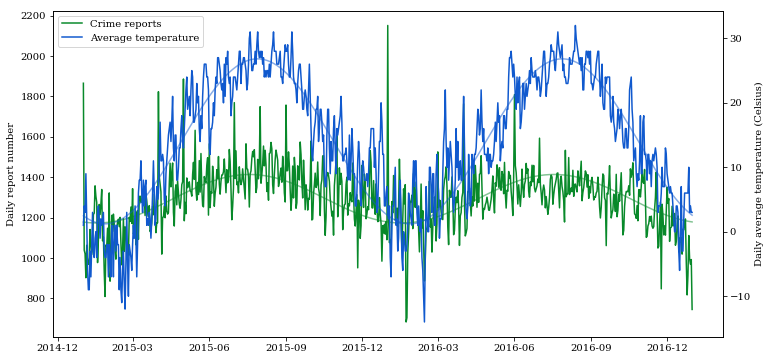

In [3]:
plt.figure(figsize=(12,6))
ax1 = plt.gca()
ax1.set_ylabel('Daily report number')
l1 = plt.plot(dates,crimesPerDate,label='Crime reports',c=MIGUELS_SELECTED_COLOR_CODES[1])
ax1.plot(dates,smoothCurve(crimesPerDate,1000),c=l1[0].get_color(),alpha=.5)

ax2 = ax1.twinx()
l2 = ax2.plot(weatherDates,weatherTemps,label='Average temperature',c=MIGUELS_SELECTED_COLOR_CODES[0])
ax2.set_ylabel('Daily average temperature (Celsius)')
ax2.plot(weatherDates,smoothCurve(weatherTemps,100),c=l2[0].get_color(),alpha=.5)

# addlegend
plt.legend((l1[0],l2[0]),('Crime reports','Average temperature'))

figureName = 'fig1_crime-vs-temperature-nyc.png'
plt.savefig(figureName, bbox_inches='tight', dpi=600)
figureName = 'fig1_crime-vs-temperature-nyc.pdf'
plt.savefig(figureName, bbox_inches='tight')

As we can see, it seems like the temperature indeed is able to influence the crime count. It's clear that their periods match exaclty which makes things more exciting. Let's quantify how relatable these quantities really are.

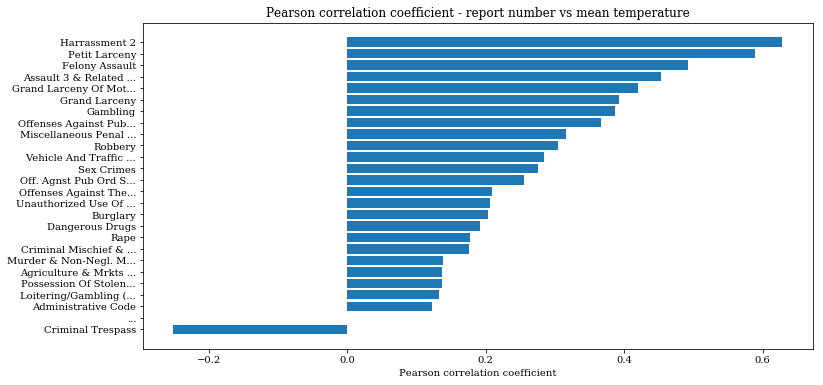

In [4]:
# Plot some specific crime types together with average temperature 
crimesPerType = nypdDataDfRed.groupby(['CMPLNT_FR_DT','OFNS_DESC']).size().unstack(fill_value=0)
crimesPerTypeDate = crimesPerType.index
crimesDateAux     = pd.to_datetime(crimesPerType.index).date

# get weather and precipitation compatible data for correlation calculations
weatherDf = weatherDf.set_index('date')
temperaturePerDay = [weatherDf['actual_mean_temp'][day] for day in crimesDateAux]   # this is for the case of uncompatible dates
precipitatiPerDay = [weatherDf['actual_precipitation'][day] for day in crimesDateAux]   # this is for the case of uncompatible dates


# compute correlation coefficients to better understand which crime types correlate with increasing Temperature
labels  = []
temperatureCrossDep     = []
precipitationCrossDep   = []
crossedDependency = {}
for column in crimesPerType:
    averageValue        = crimesPerType[column].mean()
    totalValues         = crimesPerType[column].values
    crossedDependency   = np.corrcoef([totalValues,temperaturePerDay,precipitatiPerDay])
    temperatureCrossDep.append(crossedDependency[0,1])
    precipitationCrossDep.append(crossedDependency[0,2])
    labels.append(str(column).title()[:MAX_LABEL_DIGITS] + ('...' if len(str(column))>MAX_LABEL_DIGITS else ''))


# get numpy arrays
temperatureCrossDep     = np.array(temperatureCrossDep)
precipitationCrossDep   = np.array(precipitationCrossDep)
labels                  = np.array(labels)

# temperature correlation plot
plt.figure(figsize=(12,6))
plotThreshold = 0.12
plt.title('Pearson correlation coefficient - report number vs mean temperature')
plt.xlabel('Pearson correlation coefficient')
# lets sort things and present only entries w/ coef larger than 0.12
isort                   = np.argsort(temperatureCrossDep)
sortedCrossDep          = temperatureCrossDep[isort]
irest                   = np.abs(sortedCrossDep)>plotThreshold
sortedCrossDep          = sortedCrossDep[irest]
icenter                 = np.argmax(temperatureCrossDep>0)
sortedCrossDep          = np.insert(sortedCrossDep,icenter,0.)
labelsCrossDep          = np.insert((np.array(labels.copy())[isort])[irest],icenter,'...')
pos                     = np.arange(len(labelsCrossDep)) + 0.75

plt.barh(pos,sortedCrossDep,align='center')
plt.yticks(pos,labelsCrossDep)

figureName = 'fig2_crime-type-correlation-temp-nyc.png'
plt.savefig(figureName, bbox_inches='tight', dpi=600)

It's interesting to see how indeed some crime counts are positively influenced by the average temperature. For instance, harassment correlates very well with a positive slope while criminal trespass seems to decrease with the same weather quantity.

Just as a final curiosity, we could also see the influence of the average daily precipitation:

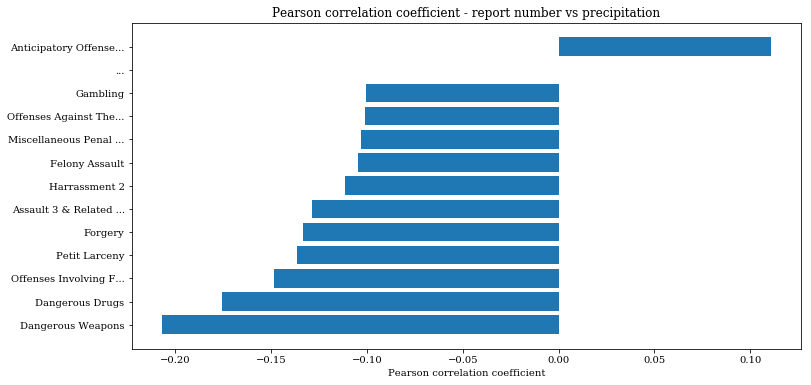

In [5]:
# precipitation correlation plot
plt.figure(figsize=(12,6))
plotThreshold = 0.10
plt.title('Pearson correlation coefficient - report number vs precipitation')
plt.xlabel('Pearson correlation coefficient')
isort                   = np.argsort(precipitationCrossDep)
sortedCrossDep          = precipitationCrossDep[isort]
irest                   = np.abs(sortedCrossDep)>plotThreshold
sortedCrossDep          = sortedCrossDep[irest]
icenter                 = np.argmax(sortedCrossDep>0)
sortedCrossDep          = np.insert(sortedCrossDep,icenter,0.)
labelsCrossDep          = np.insert((np.array(labels.copy())[isort])[irest],icenter,'...')
pos                     = np.arange(len(labelsCrossDep)) + 0.75

plt.barh(pos,sortedCrossDep,align='center')
plt.yticks(pos,labelsCrossDep)

figureName = 'fig4_crime-type-correlation-precipitation-nyc.png'
plt.savefig(figureName, bbox_inches='tight', dpi=600)

It's interesting to note how rain influences the count in a much more reduced ammount. 


I believe we can further explore these quantities with a Neural Network that includes weather forecast continuous variables as inputs and outputs the (continuous) probability of each type of crime.

Just like migration in the wildlife, nature and its cycles influence our way of living in ways we don't often think. A tool that is able to predict tendencies according to weather forecast could be extremely powerful in predicting the way we percept different kinds of information and use it to make decisions that impact our consumption habbits, relationships and actions. 

# Further investigation - gathering more variables...

In [6]:
# gething all available variables
allWeatherVariables = weatherDf.columns
print(allWeatherVariables)

Index(['actual_mean_temp', 'actual_min_temp', 'actual_max_temp',
       'average_min_temp', 'average_max_temp', 'record_min_temp',
       'record_max_temp', 'record_min_temp_year', 'record_max_temp_year',
       'actual_precipitation', 'average_precipitation', 'record_precipitation',
       'actual_snow', 'average_snow', 'snow_depth', 'sea_pressure',
       'wind_speed', 'max_wind_speed', 'max_gust_speed', 'visibility'],
      dtype='object')


In [7]:
# getting relevant variables
relevantWeatherVariables = [each for each in allWeatherVariables if not 'record' in each and not ('temp' in each and not 'mean' in each) and not ('average' in each) and not ('gust' in each) and not ('max_wind' in each)]
relevantLabels = [each.replace('_',' ').replace('actual ','').title() for each in relevantWeatherVariables]
print('Relevant variables:',', '.join(relevantLabels))

Relevant variables: Mean Temp, Precipitation, Snow, Snow Depth, Sea Pressure, Wind Speed, Visibility


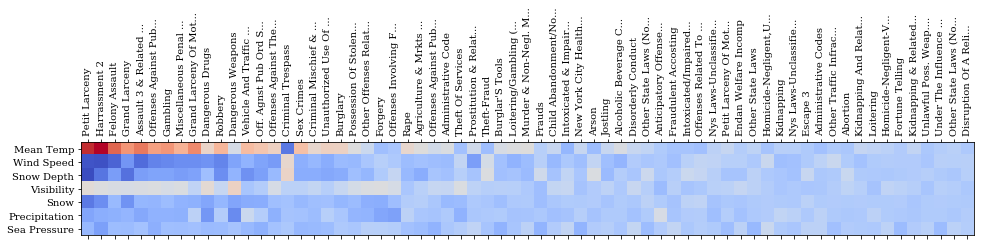

<Figure size 432x288 with 0 Axes>

In [8]:
# compute correlation coefficients matrix
crossedDependencyMatrix = []

relevantWeatherHistory = [[weatherDf[weatherVariable][day] for day in crimesDateAux] for weatherVariable in relevantWeatherVariables]

for column in crimesPerType:    
    averageValue        = crimesPerType[column].mean()
    totalValues         = crimesPerType[column].values
    crossedDependency   = np.corrcoef([totalValues] + relevantWeatherHistory)
    crossedDependencyMatrix.append(crossedDependency[0,1:])

# total crime per day
totalDependency = np.corrcoef([crimesPerDate] + relevantWeatherHistory)[0,1:]
    
# from list to matrix
crossedDependencyMatrix = np.vstack(crossedDependencyMatrix).T
    
# attempt to get some order into the variables
averageCorrelations = np.average(np.abs(crossedDependencyMatrix),axis=0)
isort = averageCorrelations.argsort()[::-1]
averageCorrelations = np.average(np.abs(crossedDependencyMatrix),axis=1)
jsort = averageCorrelations.argsort()[::-1]

plt.matshow(crossedDependencyMatrix[:,isort][jsort,:],cmap='coolwarm')
plt.xticks(range(len(labels)),np.array(labels)[isort],rotation='vertical')
plt.yticks(range(len(relevantLabels)),np.array(relevantLabels)[jsort])
plt.show()
figureName = 'fig5_crimetype-vs-weatherfactors-nyc.png'
plt.savefig(figureName, bbox_inches='tight', dpi=600)

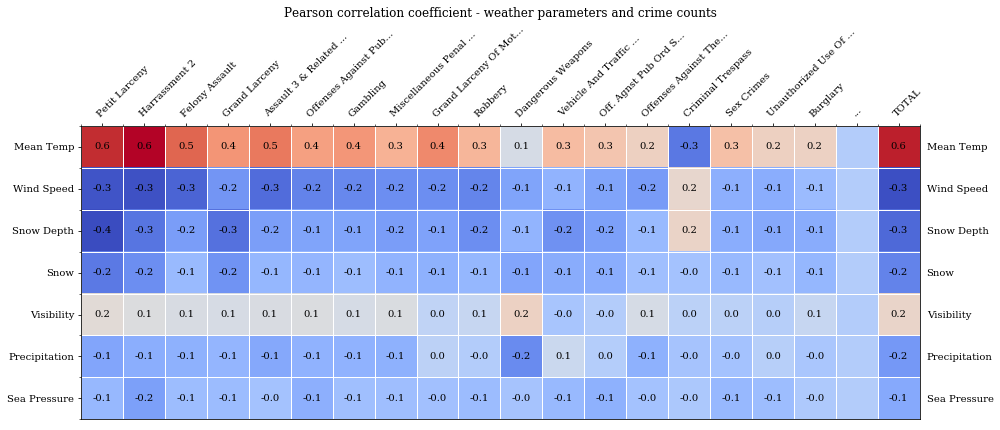

In [11]:
# present the same image with less crime types
MIN_THRESHOLD = 0.20

# transpose total dependency
totalCrimeDependency = np.array(totalDependency)
jsort = np.abs(totalCrimeDependency).argsort()[::-1]
totalCrimeDependency = totalCrimeDependency[jsort]

# filter according to the max value of each entry
minAbsCorrelations = np.max(np.abs(crossedDependencyMatrix[:,isort]),axis=0)
imins = minAbsCorrelations >= MIN_THRESHOLD

auxData   = crossedDependencyMatrix[:,isort][:,imins][jsort,:]
auxLabels = np.array(labels)[isort][imins]

addedData = np.vstack([np.zeros_like(totalCrimeDependency),totalCrimeDependency])

newData   = np.hstack([auxData,addedData.T])
newLabel  = np.append(auxLabels,['...','TOTAL'])

plt.figure(figsize=(14,8))
plt.title('Pearson correlation coefficient - weather parameters and crime counts',y=1.35)
plt.imshow(newData,cmap='coolwarm')
plt.xticks(range(len(newLabel)),newLabel,rotation=45,ha='left',rotation_mode='anchor')
plt.yticks(range(len(relevantLabels)),np.array(relevantLabels)[jsort])
ax = plt.gca()
ax.tick_params(labelbottom=False,labeltop=True)
ax.tick_params(labelright=True)

# plot values
for (j,i),value in np.ndenumerate(newData):
    if i==auxData.shape[1]:
        pass
    else:
        text = ax.text(i,j,'%.1f' % value, ha="center", va="center",color='k')

ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(-.5, len(newLabel), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(relevantLabels), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

plt.tight_layout()
figureName = 'fig6_crimetype-vs-weather-clean-nyc.png'
plt.savefig(figureName, bbox_inches='tight', dpi=400)
figureName = 'fig6_crimetype-vs-weather-clean-nyc.pdf'
plt.savefig(figureName, bbox_inches='tight')

plt.show()

This is indeed very interesting! 

So, if you want to be on the safe side, the movie cliche that foggy is unsafe might not be your best bet.
Avoid hot clear days, without snow or wind!